In [338]:
# code here copied from the Udacity course material

from io import BytesIO
import numpy as np
import cv2
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
import typing
from typing import NamedTuple
import multiprocessing
import dill as pickle
import abc
from tqdm import tqdm
%matplotlib inline   

In [10]:
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    vmax = 255 if arr.dtype == 'uint8' else 1.0
#     vmax=1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

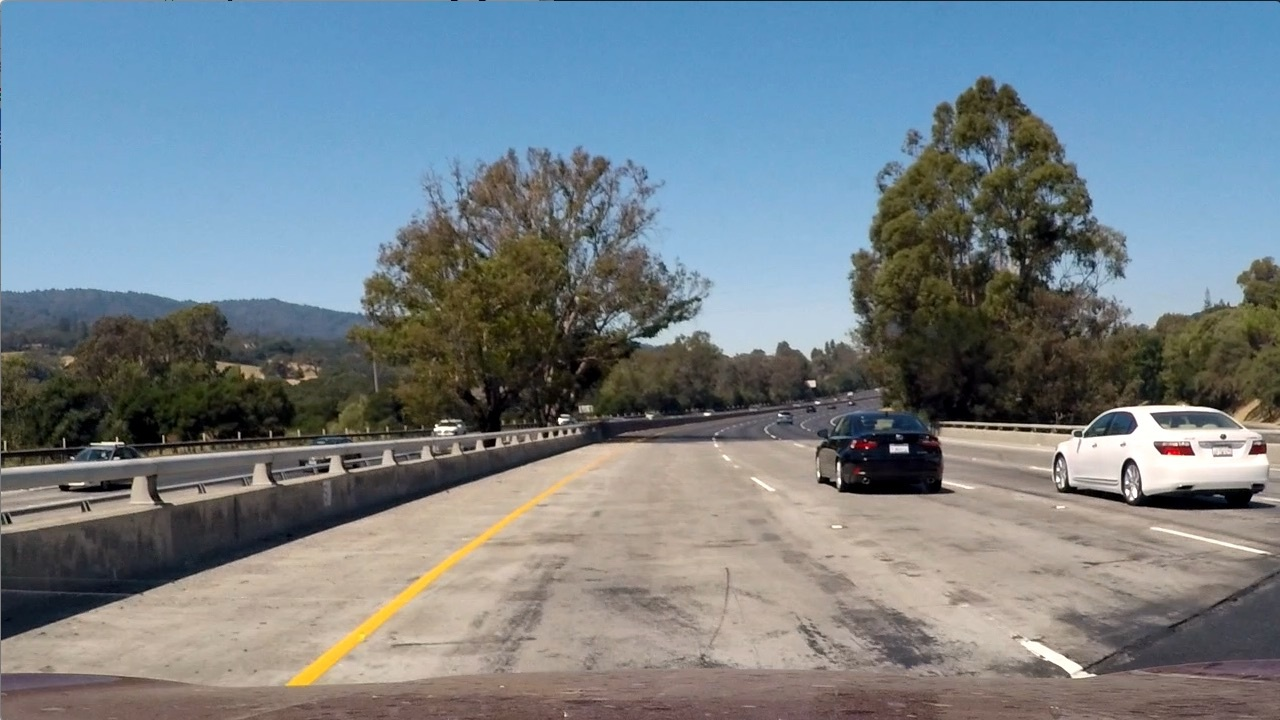

In [11]:
def load_test_images(glob_regex='test_images/*.jpg'):
    images=[]
    files=[]

    for f in glob.glob(glob_regex):
        img=cv2.imread(f)
        #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        files.append(f)
        #print(f,img.shape)
        
    return images, files

images, files = load_test_images()
arr2img(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
#arr2img(images[0][1])
#plt.imshow(images[0][1])

In [12]:
def load_images(glob_regex='var/non-vehicles/Extras/*.png'):
    
    images=[]
    files=[]
    for f in glob.glob(glob_regex):
        img=cv2.imread(f)
        images.append(img)
        files.append(f)
        
    return np.array(images), np.array(files)

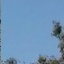

In [13]:
images, files = load_images()
arr2img(cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB))

In [14]:
def load_car_not_car_images(root_path='var', 
                            non_vehicle_sub_dirs=['Extras', 'GTI'],
                            vehicle_sub_dirs=['GTI_Far','GTI_Left','GTI_MiddleClose','GTI_Right','KITTI_extracted']):
    non_vehicle_paths=[root_path+'/non-vehicles/'+p for p in non_vehicle_sub_dirs]
    vehicle_paths=[root_path+'/vehicles/'+p for p in vehicle_sub_dirs]
    
    def images_from_path(path):
        images,files=load_images(glob_regex=path+'/*.png')
        print(path,images.shape,len(files))
        return images
    
        
    non_vehicle_images=np.concatenate([images_from_path(p) for p in non_vehicle_paths], axis=0)
    vehicle_images=np.concatenate([images_from_path(p) for p in vehicle_paths], axis=0)
    
    return vehicle_images, non_vehicle_images

In [15]:
car_images, not_car_images = load_car_not_car_images()

var/non-vehicles/Extras (5068, 64, 64, 3) 5068
var/non-vehicles/GTI (3900, 64, 64, 3) 3900
var/vehicles/GTI_Far (834, 64, 64, 3) 834
var/vehicles/GTI_Left (909, 64, 64, 3) 909
var/vehicles/GTI_MiddleClose (419, 64, 64, 3) 419
var/vehicles/GTI_Right (664, 64, 64, 3) 664
var/vehicles/KITTI_extracted (5966, 64, 64, 3) 5966


In [16]:
len(car_images)

8792

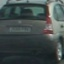

In [17]:
arr2img(cv2.cvtColor(car_images[900],cv2.COLOR_BGR2RGB))

In [273]:
class Features(object):
    """Features Class - value holder and convenience functions"""
    def __init__(self, values):
        self.__values = np.array(values)
        
    @property
    def values(self):
        return np.copy(self.__values).astype(np.float64) 
    
    @property
    def features(self):
        return self
    
    def __add__(self, other):
        if isinstance(other, ImageFeaturesBase):
            other_values=other.features.values
        elif isinstance(other, np.ndarray):
            other_vales = other
        else:
            other_values=other.values

        return Features(np.concatenate((self.values, other_values)))
    
    def __str__(self):
        return str(self.__values)
    def __repr__(self):
        return repr(self.__values)

class ImageFeaturesBase(abc.ABC):
    @property
    @abc.abstractmethod
    def image(self):
        pass
    @property
    @abc.abstractmethod
    def features(self):
        pass
    
class HogImageFeatures(ImageFeaturesBase):
    """HogImageFeatures Class"""
    def __init__(self, image, orient, pix_per_cell, cell_per_block, transform_sqrt=False):
        
        self.__image = image
        self.__orient = orient
        self.__pix_per_cell = pix_per_cell
        self.__cell_per_block = cell_per_block
        self.__transform_sqrt = transform_sqrt
        self.__hog_features = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_sqrt, 
                       visualise=False, feature_vector=False)
    @property
    def image(self):
        return self.__image
    
    @property
    def features(self):
        # vectorise the returned - storing it once
        return Features(self.__hog_features.ravel())
    
    def window_hog_features(self, window_box):

        pix_per_cell = self.__pix_per_cell
        cell_per_block = self.__cell_per_block
        orient = self.__orient
        hog_features = self.__hog_features #note will only ever be for one channel
        #print("hog_features.shape: ", hog_features.shape)
        # copied from Ryans Vehcle Detection Walkthrough
        nxblocks = (hog_features.shape[1] // pix_per_cell) - 1
        nyblocks = (hog_features.shape[0] // pix_per_cell) - 1
        nfeat_per_block = orient*cell_per_block**2
        window = 64
        nblocks_per_window = (window // pix_per_cell) - 1

        
        # unpack window coordinates and convert to cells
        wa=np.array(window_box)
        #print("window ",window)
        #print("wa ", repr(wa))
        (x1,x2) = wa[:,0]// pix_per_cell 
        (y1,y2) = wa[:,1]// pix_per_cell 
        
        #print("(x1,x2) =", (x1,x2))
        #print("(y1,y2) =", (y1,y2))
        #print("nblocks_per_window", nblocks_per_window)
        
        hog_window=hog_features[y1:y1+nblocks_per_window, x1:x1+nblocks_per_window]
        
        return Features(hog_window.ravel())
    
    def window_hog_values(self, window):
        return self.window_hog_features(window).values
    
    @property
    def values(self):
        return self.features.values
    
    def __add__(self, other):
        if isinstance(other, np.ndarray):
            other_values = other
        else:
            other_values=other.values
        return np.concatenate((self.values,other_values))
        
    @property
    def hog_image(self):
        image = self.__image
        orient = self.__orient
        pix_per_cell = self.__pix_per_cell
        cell_per_block = self.__cell_per_block
        transform_sqrt = self.__transform_sqrt
        
        
        _ , hog_image = hog(image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=transform_sqrt, 
                                  visualise=True, feature_vector=False)
        return hog_image
ImageFeaturesBase.register(HogImageFeatures)

__main__.HogImageFeatures

[ 0.12148931  0.00731083  0.00132108 ...,  0.00215775  0.00333716
  0.00089869]


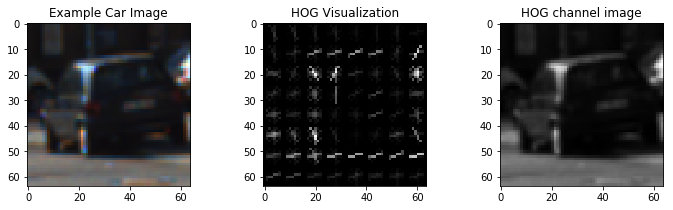

In [195]:
def test_hog(cars, ind, orient = 9, pix_per_cell =8, cell_per_block = 2):
    
    image = cars[ind]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Call our function with vis=True to see an image output
#     features, hog_image = get_hog_features(gray, orient, 
#                         pix_per_cell, cell_per_block, 
#                         vis=True, feature_vec=False)

    hif = HogImageFeatures(gray, orient, pix_per_cell, cell_per_block)
    hifw=hif.window_hog_features(((0,0),(64,64)))
    print(hifw)
    assert (hif.features.values == hifw.features.values).all()
    #print(hif.features)
    # Plot the examples
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Example Car Image')
    plt.subplot(132)
    plt.imshow(hif.hog_image, cmap='gray')
    plt.title('HOG Visualization')
    plt.subplot(133)
    plt.imshow(hif.image, cmap='gray')
    plt.title('HOG channel image')
    
ind = np.random.randint(0, len(car_images))
test_hog(car_images, ind)

In [275]:
class ChannelHistFeatures(ImageFeaturesBase):
    def __init__(self, image, channel=0, nbins=32, bins_range=(0, 256)):
        if image.shape[2] > 1:
            self.__image = image[:,:,channel]
        else:
            self.__image = image
        self.__nbins = nbins
        self.__bins_range = bins_range
    
        assert len(self.__image.shape) == 2, "Works on one color channel only"
        
    @property
    def nbins(self):
        return self.__nbins
    
    @property
    def image(self):
        return self.__image
    
    @property
    def color_channels(self):
        return 1
    
    @property
    def features(self):
        return Features(self.channel_hist(self.__image, self.__nbins, self.__bins_range))
    
    @property
    def values(self):
        return self.features.values
    
    @staticmethod
    def channel_hist(img, nbins=32, bins_range=(0,255)):
        return np.histogram(img, bins=nbins, range=bins_range)[0]
    
    def __add__(self, other):
        if isinstance(other, np.ndarray):
            other_values = other
        else:
            other_values=other.values
        return np.concatenate((self.values,other_values))

class ColorHistFeatures(ImageFeaturesBase):
    def __init__(self, image, nbins=32, bins_range=(0, 256)):
        
        self.__image = image
        self.__nbins = nbins
        self.__bins_range = bins_range
        self.__hist_features = None
      
        # derive the features
        self.__hist_features=Features([]) 
        channel_values=[]
        for channel in range(self.color_channels):
            hist = ChannelHistFeatures.channel_hist(self.__image[:,:,channel], self.__nbins, self.__bins_range)
            channel_values.append(hist)

        self.__hist_features=Features(np.concatenate(channel_values)) 
        
    @property
    def image(self):
        return self.__image
    
    @property
    def color_channels(self):
        return self.__image.shape[2]
    
    @property
    def nbins(self):
        return self.__nbins
    
    @property
    def features(self):
        return self.__hist_features 
    
    @property
    def values(self):
        return self.features.values
    
    @staticmethod
    def color_hist(img, nbins=32, bins_range=(0, 256)):
        # Udacity course example
        
        # Compute the histogram of the channels separately
        hist1 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        hist2 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        hist3 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Generating bin centers
        bin_edges = hist1[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((hist1[0], hist2[0], hist3[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist1, hist2, hist3, bin_centers, hist_features
    
    def __add__(self, other):
        if isinstance(other, np.ndarray):
            other_values = other
        else:
            other_values=other.values
        return np.concatenate((self.values,other_values))
    
ImageFeaturesBase.register(ChannelHistFeatures) 
ImageFeaturesBase.register(ColorHistFeatures)

__main__.ColorHistFeatures

<Container object of 96 artists>

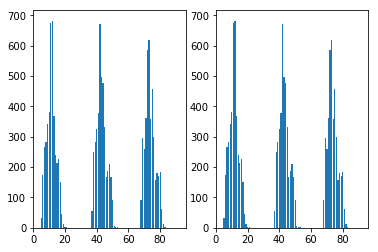

In [197]:
image=car_images[4]
chf =  ColorHistFeatures(image) # should select channel 0
values=chf.values

hist1, hist2, hist3, bin_centers, features = ColorHistFeatures.color_hist(image)

assert (values == features).all()
# full colour test
fig = plt.figure()
plt.subplot(121)
plt.xlim(0,chf.nbins*chf.color_channels)
plt.bar(np.arange(len(values)),values)
plt.subplot(122)
plt.xlim(0,chf.nbins*chf.color_channels)
plt.bar(np.arange(len(features)),features)



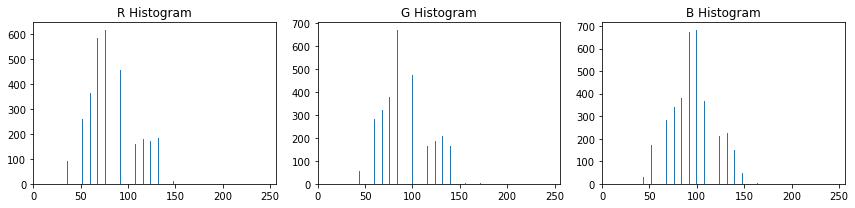

In [198]:
image=cv2.cvtColor(car_images[4], cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = ColorHistFeatures.color_hist(image, nbins=32, bins_range=(0, 256))

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.title('B Histogram')
fig.tight_layout()

In [199]:
# copied from udacity course material
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation



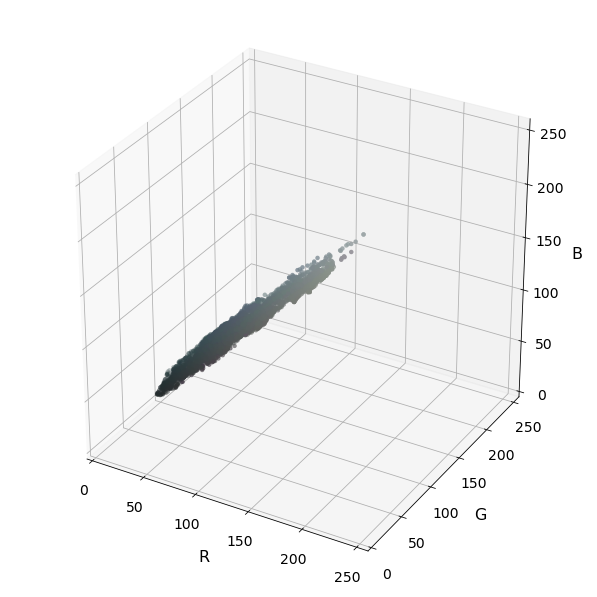

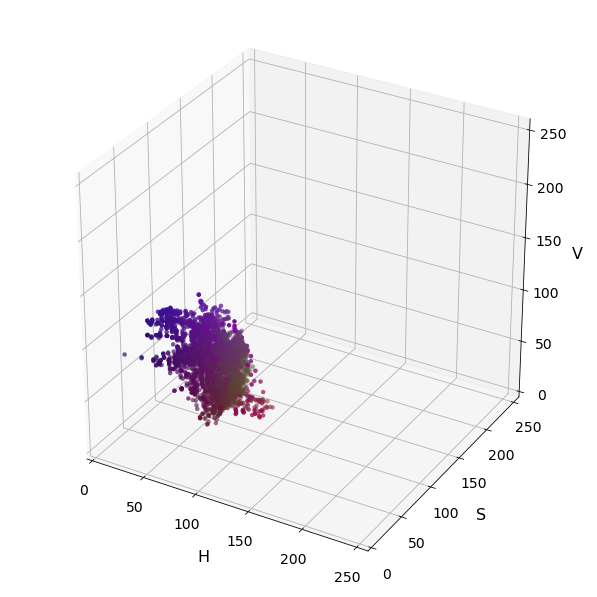

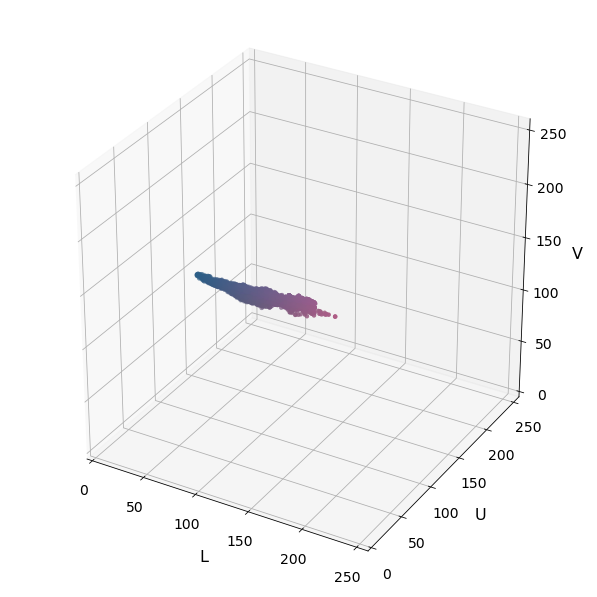

In [200]:
img=car_images[4]

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plt.show()

plot3d(img_small_HSV, img_small_HSV /255., axis_labels=list("HSV"))
plt.show()

plot3d(img_small_LUV, img_small_LUV /255., axis_labels=list("LUV"))
plt.show()

In [25]:
image=car_images[4]
small_img = cv2.resize(image, (32, 32))
print(small_img.shape)

(32, 32, 3)


In [26]:
feature_vec = small_img.ravel()
print(feature_vec.shape)

(3072,)


In [276]:
class BinSpatialFeatures(ImageFeaturesBase):
    def __init__(self, image, color_space='BGR', size=(32, 32)):
        
        self.__image = image
        self.__size = size
        self.__color_space = color_space
        
    @property
    def image(self):
        return self.__image
    
    @property
    def size(self):
        return self.__size
    
    @property
    def color_space(self):
        return self.__color_space
    
    @property
    def features(self):
        return Features(self.bin_spatial(self.image, self.color_space, self.size))
    
    @property
    def values(self):
        return self.features.values
    
    def __add__(self, other):
        if isinstance(other, np.ndarray):
            other_values = other
        else:
            other_values=other.values
        return np.concatenate((self.values,other_values))
    
    @staticmethod
    def bin_spatial(image, color_space='BGR', size=(32,32)):
        # Convert image to new color space (if specified)
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(img)             
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, size).ravel() 
        # Return the feature vector
        return features
ImageFeaturesBase.register(BinSpatialFeatures) 

__main__.BinSpatialFeatures

[ 113.   90.  139. ...,    0.    0.    0.]


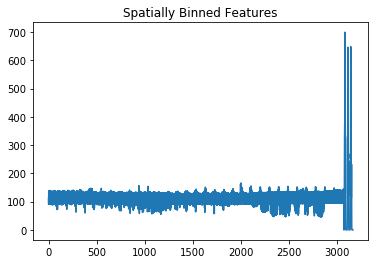

In [277]:
image=car_images[5]
#feature_vec = BinSpatialFeatures.bin_spatial(image, color_space='BGR', size=(32, 32))
chf = ColorHistFeatures(image,)    
bsf = BinSpatialFeatures(image, color_space='LUV', size=(32, 32))
feature_vec = bsf+chf
print(feature_vec)
# feature_vec = bsf.values

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

Colour Classify Example
===

In [279]:
def extract_features(imgs, cspace='BGR', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    all_features = []
    
        
    def feature_extract(image, cspace='BGR', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
        
        # apply color conversion if other than 'RGB'
        if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        else: feature_image = np.copy(image)      
 
        #bsf = BinSpatialFeatures(feature_image, size=spatial_size)
        chf = ColorHistFeatures(feature_image, nbins=hist_bins, bins_range=hist_range)
        return chf.values
    
    pbar = tqdm(total=len(imgs))
    with ThreadPoolExecutor() as executor:
        extract_futures = {executor.submit(feature_extract, img, cspace, spatial_size, hist_bins, hist_range): 
                                           img for img in imgs}
        
        for future in as_completed(extract_futures):
            img = extract_futures[future]
            try:
                features = future.result()
                pbar.update(1)
            except Exception as exc:
                print('image feature extract generated an exception: %s' % (exc))
                import sys, traceback
                exc_type, exc_value, exc_traceback = sys.exc_info()
                print(repr(traceback.format_tb(exc_traceback)))
                raise exc
            else:        
                all_features.append(features)
    pbar.close()
    return all_features

In [339]:
car_features = extract_features(car_images, cspace='LUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features(not_car_images, cspace='LUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
# Fit a per-column scaler
# X_scaler = StandardScaler(with_mean=True, with_std=True).fit(X)

X_scaler = RobustScaler().fit(X)
#X_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


100%|██████████| 8968/8968 [00:12<00:00, 741.46it/s]

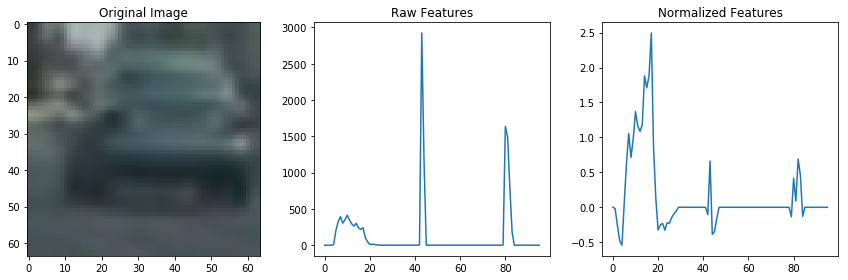

In [351]:
#car_ind = np.random.randint(0, len(car_images))
car_ind = 20
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(car_images[car_ind], cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [347]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

Test Accuracy of SVC =  0.916948198198


Hog Classify
===

In [283]:
def extract_hog_features(imgs, cspace='BGR', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    all_features = []
    
    def feature_extract(image, cspace='BGR',orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
        
        # apply color conversion if other than 'RGB'
        if cspace != 'BGR':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        else: feature_image = np.copy(image)      
 
        #bsf = BinSpatialFeatures(feature_image, size=spatial_size)
        chf = ColorHistFeatures(feature_image, nbins=hist_bins, bins_range=hist_range)

        # Call get_hog_features()
        hog_features = Features([])
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features += HogImageFeatures(feature_image[:,:,channel],orient, pix_per_cell, cell_per_block)     
        else:
            hog_features += HogImageFeatures(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block)
        
#         return np.concatenate((hog_features.values, chf.values))
        features = hog_features  + chf
        return features
    

    pbar = tqdm(total=len(imgs))
    with ThreadPoolExecutor() as executor:
        extract_futures = {executor.submit(feature_extract, img, cspace, orient, pix_per_cell, cell_per_block,
                                           hog_channel, spatial_size, hist_bins, hist_range): 
                                           img for img in imgs}
        
        for future in as_completed(extract_futures):
            img = extract_futures[future]
            try:
                features = future.result()
                pbar.update(1)
            except Exception as exc:
                print('image feature extract generated an exception: %s' % (exc))
                import sys, traceback
                exc_type, exc_value, exc_traceback = sys.exc_info()
                print(repr(traceback.format_tb(exc_traceback)))
                raise exc
            else:        
                all_features.append(features.values)
    pbar.close()
    return all_features

In [352]:
# sample_size = 10000
# cars = car_images[0:sample_size]
# notcars = not_car_images[0:sample_size]

cars = car_images
notcars = not_car_images

colorspace = 'LUV' # Can be BGR, HSV, LUV, HLS, YUV
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler(with_mean=True, with_std=True).fit(X)
X_scaler = RobustScaler().fit(X)
# X_scaler = MinMaxScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


100%|██████████| 8968/8968 [00:25<00:00, 352.91it/s]

50.8 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1860


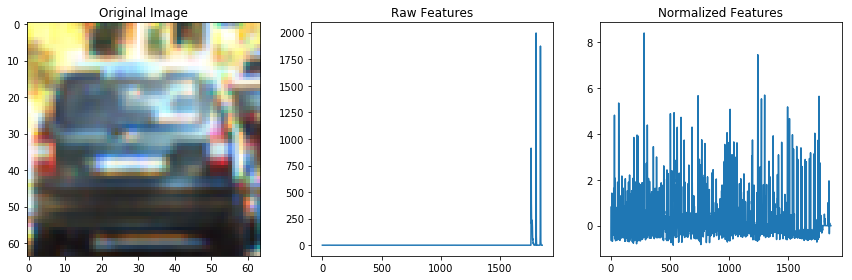

In [361]:
car_ind = np.random.randint(0, len(car_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(car_images[car_ind], cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [362]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

4.28 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9837
My SVC predicts:  [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
0.00288 Seconds to predict 10 labels with SVC


In [363]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1,max_depth=None, min_samples_split=10, random_state=0)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train ExtraTrees...')
# Check the score of the RandomForest
print('Train Accuracy of  ExtraTrees = ', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of ExtraTrees = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My ExtraTrees predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with ExtraTrees')

3.23 Seconds to train ExtraTrees...
Train Accuracy of  ExtraTrees =  1.0
Test Accuracy of ExtraTrees =  0.9856
My ExtraTrees predicts:  [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
0.1085 Seconds to predict 10 labels with ExtraTrees


In [364]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=None, min_samples_split=10, random_state=0)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train RandomForest...')
# Check the score of the RandomForest
print('Train Accuracy of RandomForest = ', round(clf.score(X_train, y_train), 4))
print('Test Accuracy of RandomForest = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My RandomForest predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RandomForest')

6.11 Seconds to train RandomForest...
Train Accuracy of RandomForest =  1.0
Test Accuracy of RandomForest =  0.9918
My RandomForest predicts:  [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  1.  0.  1.  0.  0.  1.]
0.10797 Seconds to predict 10 labels with RandomForest


In [365]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

(720, 1280, 3)


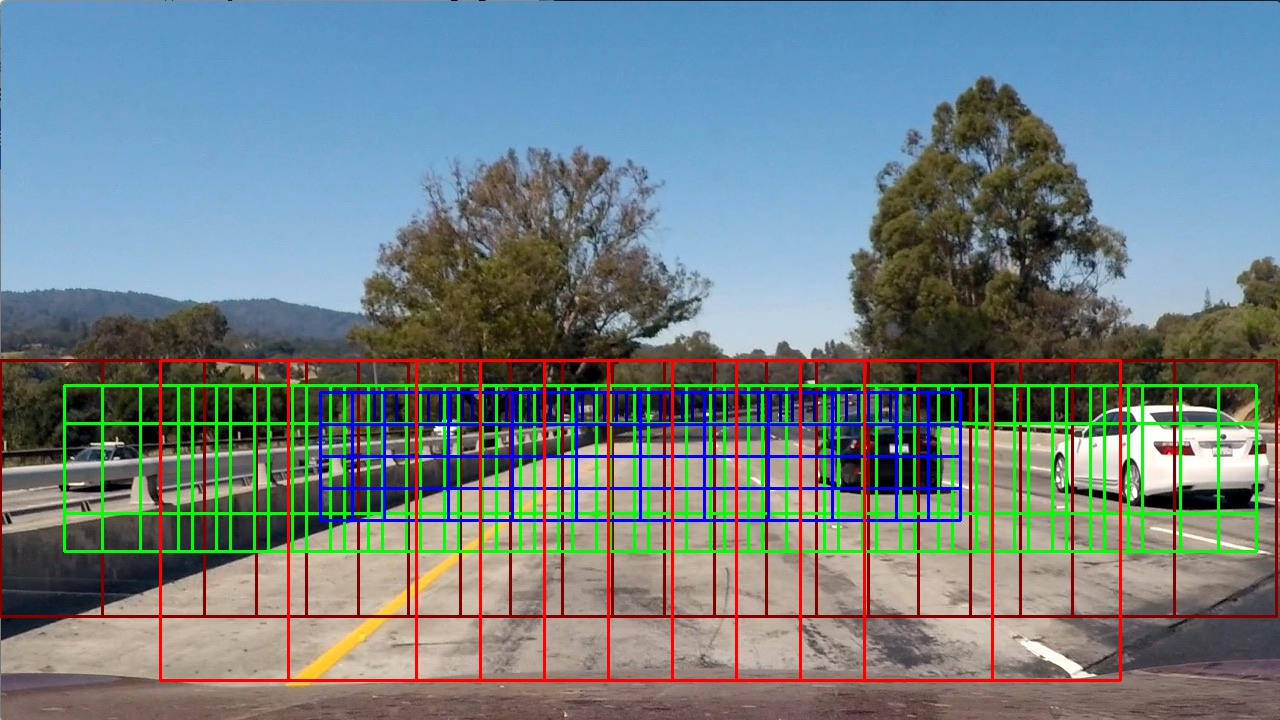

In [366]:
images, _ = load_test_images()

class WindowBoxes(object):
    """WindowBoxes class - all things to do with boxes"""
    
    def __init__(self, height, width):
        
        self.__sz_dict = self.spatial_sizes_dict()
        self.__wb_dict = self.build_window_boxes(height, width)
        self.__height = height
        self.__width = width
        self.__bounding_box_dict = {key:None for key, _ in self.__sz_dict.items()} # build later
        
    
    @property
    def spatial_sizes_dict(self):
        return self.__sz_dict
    
    @property
    def shape_keys(self):
        return [key for key, _ in self.__sz_dict.items()]
        
    @property
    def window_boxes_dict(self):
        return self.__wb_dict
    
    @property
    def box_colour_dict(self):
        box_color={}
        box_color["small"]=(0,0,128)
        box_color["smallish"]=(0,0,256)
        box_color["medium"]=(0,256,0)
        box_color["large"]=(128,0,0)
        box_color["max"]=(256,0,0)
        return box_color

    @property
    def height(self):
        return self.__height
    
    @property
    def width(self):
        return self.__width
    
    def windows(self, shape):
        return self.window_boxes_dict[shape]
    
    def bounding_box(self, shape):
        bb = self.__bounding_box_dict[shape]
        if bb is None:
            pts=np.array(self.window_boxes_dict[shape]).reshape(-1,2)

            pts_x,pts_y=pts[:,0],pts[:,1]

            min_x,max_x=np.min(pts_x),np.max(pts_x)
            min_y,max_y=np.min(pts_y),np.max(pts_y)
            
            bb = ((min_x,min_y),(max_x,max_y))
            self.__bounding_box_dict[shape] = bb
            
        return bb
    
    def bounding_box_origin(self, shape):
        return self.bounding_box(shape)[0]
        
    @staticmethod
    def spatial_sizes_dict():
        sz_dict={}
        sz_dict["small"]=(32,32)
        sz_dict["smallish"]=(64,64)
        sz_dict["medium"]=(128,128)
        sz_dict["large"]=(256,256)
        sz_dict["max"]=(320,320)
        return sz_dict

    @staticmethod
    def resize_64x64_ratio(shape):
        size = WindowBoxes.spatial_sizes_dict()[shape][0]
        return 64./size
        
    @staticmethod
    def build_window_boxes(height, width, all_shapes=True, shape="small"):
        # Define a function that takes an image,
        # start and stop positions in both x and y, 
        # window size (x and y dimensions),  
        # and overlap fraction (for both x and y)
        def slide_window(height, width, x_start_stop=[None, None], y_start_stop=[None, None], 
                            xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
            # If x and/or y start/stop positions not defined, set to image size
            if x_start_stop[0] == None:
                x_start_stop[0] = 0
            if x_start_stop[1] == None:
                x_start_stop[1] = width
            if y_start_stop[0] == None:
                y_start_stop[0] = 0
            if y_start_stop[1] == None:
                y_start_stop[1] = height
            # Compute the span of the region to be searched    
            xspan = x_start_stop[1] - x_start_stop[0]
            yspan = y_start_stop[1] - y_start_stop[0]
            # Compute the number of pixels per step in x/y
            nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
            ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
            # Compute the number of windows in x/y
            nx_windows = np.int(xspan/nx_pix_per_step) - 1
            ny_windows = np.int(yspan/ny_pix_per_step) - 1
            # Initialize a list to append window positions to
            window_list = []
            # Loop through finding x and y window positions
            # Note: you could vectorize this step, but in practice
            # you'll be considering windows one by one with your
            # classifier, so looping makes sense
            for ys in range(ny_windows):
                for xs in range(nx_windows):
                    # Calculate window position
                    startx = xs*nx_pix_per_step + x_start_stop[0]
                    endx = startx + xy_window[0]
                    starty = ys*ny_pix_per_step + y_start_stop[0]
                    endy = starty + xy_window[1]
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
            # Return the list of windows
            return window_list


        def find_windows(height, width, xc=7, yc=2.5, xy_window=(32,32), xy_overlap=(0.5,0.5)):
            y_center=height//2
            x_center=width//2
            x,y = xy_window
            y_start = y_center 
            if y == 32: 
                y_start = y_center+y
            elif y == 64:
                y_start = y_center+np.int(y/2)
            elif y == 128:
                y_start = y_center+25
            elif y == 256:
                y_start = y_center 
            elif y == 384:
                y_start = y_center
            y_stop = image.shape[0] - 150 # for bonnet
            if y <= 128:
                y_stop = y_center+np.int(y*yc) 
            windows = slide_window(height, width, x_start_stop=[x_center-np.int(x*xc),x_center+np.int(x*xc)], y_start_stop=[y_start,y_center+np.int(y*yc)], 
                            xy_window=xy_window, xy_overlap=xy_overlap)

            return windows

        sz_dict = WindowBoxes.spatial_sizes_dict()

        window_dict={}
        window_dict["small"] = find_windows(height, width,xc=9, yc=2.5, xy_window=sz_dict['small'], xy_overlap=(0.3,0.3)) 
        window_dict["smallish"] = find_windows(height, width, xc=5, yc=2.5, xy_window=sz_dict['smallish'], xy_overlap=(0.5,0.5))
        window_dict["medium"] = find_windows(height, width, xc=4.5, yc=1.25, xy_window=sz_dict['medium'], xy_overlap=(0.7,0.7))
        window_dict["large"] = find_windows(height, width, xc=2.5, yc=1, xy_window=sz_dict['large'], xy_overlap=(0.6,0.6))
        window_dict["max"] = find_windows(height, width, xc=1.5, yc=1, xy_window=sz_dict['max'], xy_overlap=(0.6,0.6)) 

        # if not all shapes then overwrite with just the shape required
        if all_shapes != True:
            window_dict={shape: window_dict[shape]}

        return window_dict
    
@interact
def window_test(images=fixed(images), i:(0,len(images)-1)=0, 
                all_shapes=True,
                shape:["small","smallish","medium","large","max"]="small"):    
    image=cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    print(image.shape)
    height = image.shape[0]
    width = image.shape[1]
    wb = WindowBoxes(height, width)
    box_color=wb.box_colour_dict

    window_dict = wb.build_window_boxes(height, width, all_shapes, shape) 
    window_img=np.copy(image)
    for size, windows in window_dict.items():
        window_img = draw_boxes(window_img, windows, color=box_color[size], thick=2)   
    
    return arr2img(window_img)

In [367]:
# initialise an object to contain common parameters
color_space = 'LUV' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0,256)
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

class SearchParams(typing.NamedTuple("GenSearchParams", [('color_space', str),('orient', int),('pix_per_cell', int),
                                                         ('cell_per_block', int),('hog_channel', int),
                                                         ('spatial_size', tuple), 
                                                         ('hist_bins', int),('hist_range', tuple),
                                                         ('spatial_feat', bool),
                                                         ('hist_feat', bool), ('hog_feat', bool),
                                                         ('clf',LinearSVC), ('X_scaler', StandardScaler)
                                                        ])):
    pass
    
search_params = SearchParams(color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size,
                  hist_bins, hist_range, spatial_feat, hist_feat, hog_feat, svc, X_scaler)
print(search_params)

SearchParams(color_space='LUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), spatial_feat=False, hist_feat=True, hog_feat=True, clf=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), X_scaler=RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))


In [368]:
class CameraImage(object):
    """holds an image and does color space conversions """
    def __init__(self, image:np.ndarray, color_space:str='BGR'):
        self.__color_space = color_space
        
        # want to make sure its stored as BGR if possible
        if color_space == 'BGR':
            self.__image = image
        elif color_space == 'RGB':
            self.__image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        else:
            self.__image = image
            
        # double check scaling 
        assert np.max(self.__image) >= 1 
        
        # this gets created as we need it once only
        self.__hog_features = None
            
    @property
    def image(self):
        return self.__image
    
    @property
    def height(self):
        return self.__image.shape[0]
    
    @property
    def width(self):
        return self.__image.shape[1]
    
    @property
    def channels(self):
        return self.__image.shape[2]
    
    @property
    def y_center(self):
        return np.int(self.height/2)
    
    @property
    def image_bottom(self):
        return self.image[self.y_center:self.height]
    
    @property
    def rgb(self):
        return cv2.cvtColor(self.__image, cv2.COLOR_BGR2RGB)
    
    def to_color_space(self, color_space):
        return self.convert_color_space(self.__image, color_space)
    
    @staticmethod
    def slice_window(image, window):
        return image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    
    @staticmethod
    def slice_bounding_box_shape_resize_64x64(image, wb:WindowBoxes, shape:str):
        """resize to (64,64) to match trained data size"""
        window=wb.bounding_box(shape)
        ratio=wb.resize_64x64_ratio(shape)
        
        if ratio < 1:
            # shrinking
            image = cv2.resize(CameraImage.slice_window(image, window), None, fx=ratio, fy=ratio, interpolation=cv2.INTER_AREA) 
        else:
            # zooming
            image = cv2.resize(CameraImage.slice_window(image, window), None, fx=ratio, fy=ratio, interpolation=cv2.INTER_LINEAR)
        return image
        
    
    @staticmethod
    def convert_color_space(image, color_space):
        img = np.copy(image)
        if color_space != 'BGR':
            if color_space == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        return img
    
    def hog_features(self, sp:SearchParams):
        ### once off creation of hog_features for the bottom half of the screen
        if self.__hog_features == None:
            hog_channel, orient  = search_params.hog_channel, search_params.orient
            pix_per_cell, cell_per_block = search_params.pix_per_cell, search_params.cell_per_block
            self.__hog_features = self.hog_features_list(self.image_bottom, hog_channel, orient, pix_per_cell, cell_per_block)
        return self.__hog_features
    
    @staticmethod
    def hog_channel_features(img_channel, sp:SearchParams, vis=False, feature_vec=False, transform_sqrt=False):
        orient, pix_per_cell, cell_per_block = search_params.orient, search_params.pix_per_cell, search_params.cell_per_block
        hif = HogImageFeatures(img_channel,orient, pix_per_cell, cell_per_block)
        return hif.features
        
    @staticmethod
    def hog_features_list(img, hog_channel, orient, pix_per_cell, cell_per_block, color_space='BGR'):
        if color_space != 'BGR':
            img = CameraImage.convert_color_space(img, color_space)
        hif_list = []
        if hog_channel == 'ALL':
            for channel in range(img.shape[2]):
                hif_list.append(HogImageFeatures(img[:,:,channel],orient, pix_per_cell, cell_per_block))   
        else:
            hif_list.append(HogImageFeatures(img[:,:,hog_channel], orient, pix_per_cell, cell_per_block))
                    
        return hif_list
    
    @staticmethod
    def bin_spatial(img, color_space='BGR', size=(32, 32)):
        if color_space != 'BGR':
            img = CameraImage.convert_color_space(img, colour_space)
        bsf = BinSpatialFeatures(img, size=spatial_size)
        return bsf.features
    
    @staticmethod
    def color_hist(img, color_space='BGR', nbins=32, bins_range=(0, 256)):
        if color_space != 'BGR':
            img = CameraImage.convert_color_space(img, colour_space)
        chf = ColorHistFeatures(img, nbins=hist_bins, bins_range=bins_range)

        return chf.features

((352, 392), (912, 424)) 2.0 (64, 1120, 3)


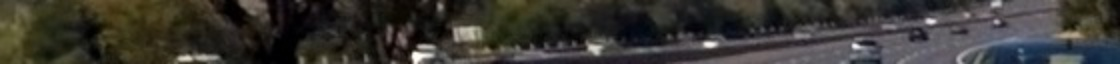

In [369]:
@interact
def camera_window_box_test(images=fixed(images), i:(0,len(images)-1)=0, shape:["small","smallish","medium","large","max"]="small"):
    camera_image=CameraImage(images[i])
    window_boxes=WindowBoxes(camera_image.height, camera_image.width)               

    img=CameraImage.slice_bounding_box_shape_resize_64x64(camera_image.image, window_boxes, shape)
    print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), img.shape)
    return arr2img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [379]:
class WindowBoxSlice(typing.NamedTuple("GenWindowSlice", [('bbox', tuple),('bbox_slice', tuple)])):
    pass                 
                     
class ImageSlice(object):
    """holds an image slice and does feature searches """
    def __init__(self, camera_image:CameraImage, window_boxes:WindowBoxes, search_params:SearchParams, shape:str):
        self.__camera_image = camera_image
        self.__window_boxes = window_boxes
        self.__search_params = search_params
        self.__shape = shape
        self.__image = None
        self.__hog_features = None
        
    @property
    def image(self):
        if self.__image is None:
            camera_image = self.__camera_image
            window_boxes = self.__window_boxes
            shape = self.__shape
            self.__image = CameraImage.slice_bounding_box_shape_resize_64x64(camera_image.image, window_boxes, shape)
        return self.__image
    
    @property
    def image_color_converted(self):
        sp = self.__search_params
        if search_params.color_space == 'BGR':
            return self.image
        else:
            return CameraImage.convert_color_space(self.image, search_params.color_space)
     
    @property
    def shape(self):
        return self.__shape
    
    @property
    def bin_spatial_features(self):
        sp = self.__search_params
        return CameraImage.bin_spatial(self.image_color_converted, size=search_params.spatial_size)
    
    def slice_window(self, window):
        return self.image_color_converted[window[0][1]:window[1][1], window[0][0]:window[1][0]]
    
    def window_bin_spatial_features(self, window):
        sp = self.__search_params
        return CameraImage.bin_spatial(self.slice_window(window), size=search_params.spatial_size)
        
    @property
    def color_hist_features(self):
        sp = self.__search_params
        return CameraImage.color_hist(self.image_color_converted, nbins=search_params.hist_bins, )
    
    def window_color_hist_features(self, window):
        sp = self.__search_params
        return CameraImage.color_hist(self.slice_window(window), nbins=search_params.hist_bins,
                                      bins_range=search_params.hist_range)
        
    @property
    def hog_features_list(self): 
        # its expensive to create so do it once per image slice and store it
        if self.__hog_features is None:
            sp = self.__search_params
            self.__hog_features = self.__camera_image.hog_features_list(self.image, sp.hog_channel, sp.orient,
                                                                         sp.pix_per_cell, sp.cell_per_block,
                                                                         sp.color_space)
        
        return self.__hog_features 
    
    def hog_image(self, channel):
        image = self.__image
        orient = self.__search_params.orient
        pix_per_cell = self.__search_params.pix_per_cell
        cell_per_block = self.__search_params.cell_per_block
        
        _ , hog_image = hog(image[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return hog_image
    
    
    def window_hog_features(self, window):
        # add all the features from all hog channel windows
        features=Features([])
        for hif in self.hog_features_list:
            features += hif.window_hog_features(window)
            
        return features
        
    def window_generator(self):
        """transform window points to meet the coordinates of this image slice"""
        wb = self.__window_boxes
        shape = self.__shape
        bb_origin = wb.bounding_box_origin(shape)
        ratio = wb.resize_64x64_ratio(shape)
        for window in wb.windows(shape):
            new_window = np.multiply(np.subtract(window, bb_origin),(ratio,ratio)).astype(int)
            yield WindowBoxSlice(window, new_window)

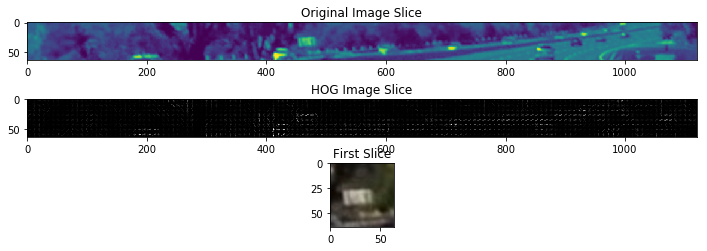

In [381]:
## initialise an object to contain common parameters
color_space = 'LUV' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0,256)
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

class SearchParams(typing.NamedTuple("GenSearchParams", [('color_space', str),('orient', int),('pix_per_cell', int),
                                                         ('cell_per_block', int),('hog_channel', int),
                                                         ('spatial_size', tuple), 
                                                         ('hist_bins', int),('hist_range', tuple),
                                                         ('spatial_feat', bool),
                                                         ('hist_feat', bool), ('hog_feat', bool),
                                                         ('clf', LinearSVC), ('X_scaler', RobustScaler)
                                                        ])):
    pass
    
search_params = SearchParams(color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size,
                  hist_bins, hist_range, spatial_feat, hist_feat, hog_feat, svc, X_scaler)

@interact
def hog_slice_test(images=fixed(images), i:(0,len(images)-1)=0,
                   shape:["small","smallish","medium","large","max"]="small"):
    camera_image = CameraImage(images[i])
    window_boxes = WindowBoxes(camera_image.height, camera_image.width)
    image_slice = ImageSlice(camera_image, window_boxes, search_params, shape)
    image_windows = [wbs for wbs in image_slice.window_generator()]
    image = image_slice.image

    hog_image = image_slice.hog_image(0)
#     print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), image.shape)
  
    hog_features_list = image_slice.hog_features_list
#     print(len(hog_features_list))
#     print("hog_features_list[0].values.shape=",hog_features_list[0].values.shape)
#     print(image_slice.image.shape,hog_image.shape)
    #print(window_boxes.windows(shape))
#     print(image_windows)

#     for w in image_windows:
#         print("windows: %r slice_window %r hog: %r" % (w.bbox, w.bbox_slice,
#                                                        image_slice.window_hog_features(w.bbox_slice)))
    fig = plt.figure(figsize=(12,4))
    plt.subplot(311)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,0])
    plt.title('Original Image Slice')
    plt.subplot(312)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Image Slice')
    plt.subplot(313)
    plt.imshow(hog_image, cmap='gray')
    plt.title('First Slice')
    plt.imshow(cv2.cvtColor(image_slice.slice_window(image_windows[10].bbox_slice), cv2.COLOR_LUV2RGB))         

In [382]:
class VehicleDetection(object):
    """Vehicle Detection class - holds all things to do with vehicle detection """
    def __init__(self, search_params:SearchParams, height, width):
        self.__height = height  # of images being used
        self.__width = width  # of image beinf used
        self.__search_params = search_params #global parameters for all objects
        self.__window_boxes = WindowBoxes(height, width)
 
        self.__image = None 
        self.__camera_image = None
        self.__hot_windows = None
    
    @property
    def img_height(self):
        return self.__height
    @property
    def img_width(self):
        return self.__width
    
    @property
    def image(self):
        return self.__image
    
    @property
    def window_boxes(self):
        return self.__window_boxes
    
    @property
    def camera_image(self):
        return self.__camera_image
    
    @property
    def search_parameters(self):
        return self.__search_params
    
    @image.setter
    def image(self, image):
        # make sure its a bgr image being passed in
        self.__image = image
        self.__camera_image = CameraImage(image)
        
        
    @property
    def hot_windows(self):
        if self.__hot_windows is None:
            self.__hot_windows = self.hot_windows_search(self.camera_image, self.window_boxes, self.search_parameters)
        return self.__hot_windows
        
    @property
    def result_decorated(self):
        # TODO change this back to bgr image - ok whilst testing
        window_img = draw_boxes(self.camera_image.rgb, self.hot_windows, color=(0, 0, 255), thick=2) 
        return window_img
        
    @staticmethod    
    def single_window_features(image_slice:ImageSlice, wbs:WindowBoxSlice, search_params:SearchParams):    
        features = Features([])
        window = wbs.bbox_slice # use the slice window bounding box

        
        if search_params.hog_feat == True:
            hog_features = image_slice.window_hog_features(window)
            # print("hog_features {}".format(hog_features))
            features += hog_features
            
        if search_params.spatial_feat == True:
            image_features = image_slice.window_bin_spatial_features(window)
            # print("image_features {}".format(image_features))
            features += image_features

        if search_params.hist_feat == True:
            hist_features = image_slice.window_color_hist_features(window)
            # print("hist_features {}".format(hist_features))
            features += hist_features
       
        float_values = features.values.astype(np.float64) 
#         print("window: {} {} float_values.shape {}".format (window, image_slice.shape,  float_values.shape))
        
        return float_values

    
    @staticmethod
    def search_windows_generator(camera_image:CameraImage, window_boxes:WindowBoxes, search_params:SearchParams):
        for shape in window_boxes.shape_keys:
            # the image slice processes the image for the window shape
            image_slice = ImageSlice(camera_image, window_boxes, search_params, shape)
            
            for wbs in image_slice.window_generator():
                # print("yielding: ", shape, wbs.bbox, wbs.bbox_slice)
                yield (image_slice, wbs, shape)

    def hot_windows_search(self, camera_image:CameraImage, window_boxes:WindowBoxes, search_params:SearchParams):
        hot_windows=[]
        swg = self.search_windows_generator(camera_image, window_boxes, search_params)
        
        
        def feature_prediction(image_slice:ImageSlice, wbs:WindowBoxSlice):
            clf = search_params.clf
            X_scaler = search_params.X_scaler

            # todo extract out just the image
            features = self.single_window_features(image_slice, wbs, search_params)
            scaled_features = X_scaler.transform(features.reshape(1,-1))

            prediction = clf.predict(scaled_features)
            
            return prediction
        
        with ThreadPoolExecutor() as executor:
            # wbs contains a WindowBoxSlice object with original bbox window and slice bbox window
            feature_prediction_futures = {executor.submit(feature_prediction, image_slice, wbs): 
                                          (image_slice, wbs, shape) for (image_slice, wbs, shape) in swg}

            for future in as_completed(feature_prediction_futures):
                (image_slice, wbs, shape) = feature_prediction_futures[future]
                try:
                    prediction = future.result()
                except ValueError as exc:
                    print("ValueError: window: {} {} msg {}".format(window, shape, exc))
                except Exception as exc:
                    print('(image_slice, window, shape) %r generated an exception: %s' % ((image_slice, window, shape), exc))
                    import sys, traceback
                    exc_type, exc_value, exc_traceback = sys.exc_info()
                    print(repr(traceback.format_tb(exc_traceback)))
                    raise exc

                else:
                    if prediction == 1:
                        #append the bounding box for the original window
                        hot_windows.append(wbs.bbox)

        return hot_windows    

[ 0.] for [[ 0  0]
 [64 64]] total detection time: 0.005880117416381836 transform time: 7.891654968261719e-05 prediction time: 6.699562072753906e-05
[ 0.] for [[25  0]
 [89 64]] total detection time: 0.0011241436004638672 transform time: 8.20159912109375e-05 prediction time: 7.104873657226562e-05
[ 0.] for [[ 51   0]
 [115  64]] total detection time: 0.0010678768157958984 transform time: 7.700920104980469e-05 prediction time: 7.104873657226562e-05
[ 0.] for [[ 76   0]
 [140  64]] total detection time: 0.0011429786682128906 transform time: 0.00010514259338378906 prediction time: 7.390975952148438e-05
[ 0.] for [[102   0]
 [166  64]] total detection time: 0.001068115234375 transform time: 7.796287536621094e-05 prediction time: 6.794929504394531e-05
[ 0.] for [[128   0]
 [192  64]] total detection time: 0.0012750625610351562 transform time: 8.106231689453125e-05 prediction time: 6.985664367675781e-05


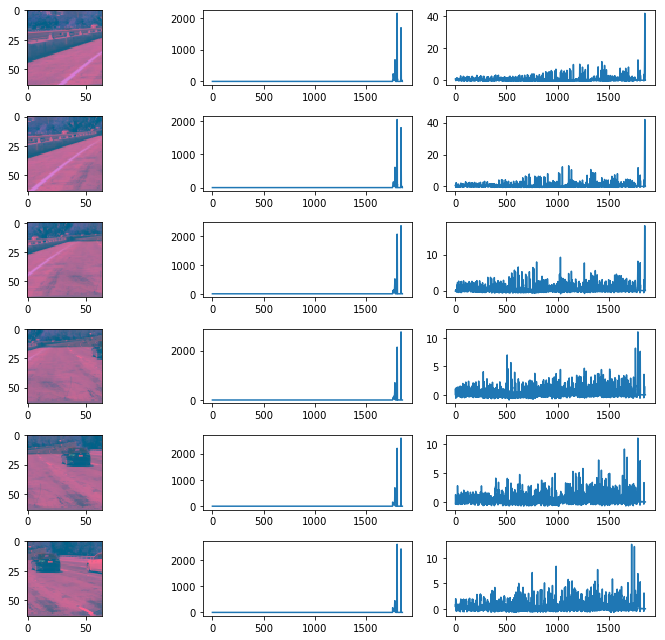

In [383]:
@interact
def single_windows_features_test(images=fixed(images), i:(0,len(images)-1)=0,
                                 shape:["small","smallish","medium","large","max"]="max"):

    vehicle_detection = VehicleDetection(search_params,images[i].shape[0], images[i].shape[1])
    vehicle_detection.image = images[i]

    camera_image = vehicle_detection.camera_image
    window_boxes = vehicle_detection.window_boxes

    image_slice = ImageSlice(camera_image, window_boxes, search_params, shape)

    nboxes=len(window_boxes.window_boxes_dict[shape])
    fig = plt.figure(figsize=(10,nboxes*1.5))

    i = 0
    for wbs in image_slice.window_generator():

        t=time.time()
        features = VehicleDetection.single_window_features(image_slice, wbs, search_params)
        t2=time.time()
#         print("{} detected {} features {} secs".format(window,len(features),t2-t))
        #X=[features]
        scaled_features = search_params.X_scaler.transform(features.reshape(1,-1))
        t3=time.time()
#         print("feature scale time {}".format(t3-t2))

#         print("scaled_X {}".format(scaled_X))
        prediction = search_params.clf.predict(scaled_features)
        t4=time.time()
        print("{} for {} total detection time: {} transform time: {} prediction time: {}".format(prediction,wbs.bbox_slice,t2-t,t3-t2,t4-t3))
        # plotting is slow
        plt.subplot(nboxes, 3, (i*3)+1)
        plt.imshow(image_slice.slice_window(wbs.bbox_slice))
        #plt.xticks([]), plt.yticks([])
        plt.subplot(nboxes, 3, (i*3)+2)
        plt.plot(features)
        plt.subplot(nboxes, 3, (i*3)+3)
        plt.plot(scaled_features[0])
        fig.tight_layout()
        i += 1

    plt.show

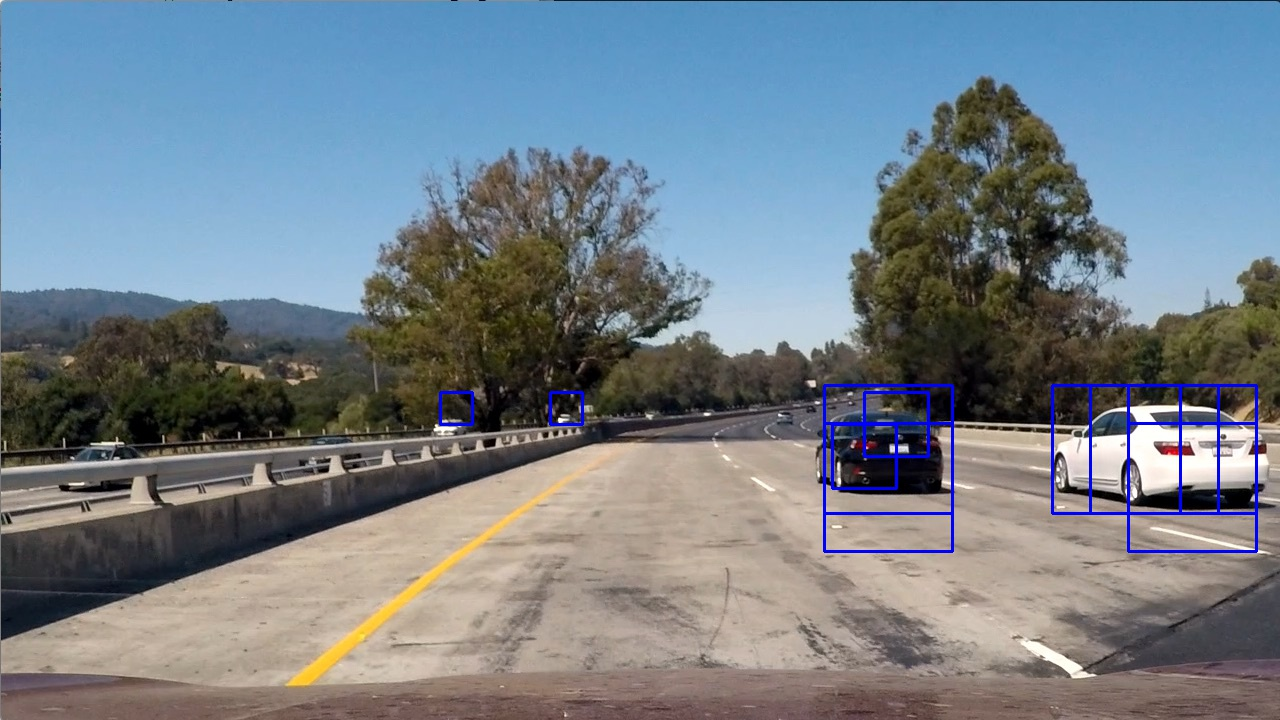

In [384]:
@interact
def hot_windows_test(images=fixed(images), i:(0,len(images)-1)=0, shape:["small","smallish","medium","large","max"]="small"):

    vehicle_detection = VehicleDetection(search_params,images[i].shape[0], images[i].shape[1])
    vehicle_detection.image = images[i]
    return arr2img(vehicle_detection.result_decorated)
#    camera_image=CameraImage(images[i])
#    window_boxes=WindowBoxes(camera_image.height, camera_image.width)
#     image=camera_image.image_bottom
#     print(camera_image.image_bottom.shape)
#     print(camera_image.hog_features(search_params))
#     features,hog_image = camera_image.hog_channel_features(image[:,:,2],search_params,vis=True,feature_vec=True)
#     print(features.shape)
#     return arr2img(hog_image)
    #hot_windows=hot_windows_search(camera_image, window_boxes, search_params)
    #window_img = draw_boxes(camera_image.rgb, hot_windows, color=(0, 0, 255), thick=2)                    

#     image=CameraImage.slice_bounding_box_shape_resize_64x64(camera_image, window_boxes, shape)
#     features,hog_image = camera_image.hog_channel_features(image[:,:,2],search_params,vis=True,feature_vec=True)
#     print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), img.shape)
#     return arr2img(hog_image)

In [ ]:
windows_dict = build_window_boxes(images[0])

In [ ]:
print(windows_dict['smallish'])

In [ ]:
ci=CameraImage(images[0])
wb=WindowBoxes(ci.height, ci.width)
wb.bounding_box('small')

In [ ]:
WindowBoxes.resize_64x64_ratio("small")